# 1D CNN Two Blocks

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter

from torchinfo import summary

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

from tqdm import tqdm

In [2]:
DATA_PATH = "../data/filtered_df.csv"
SAVED_MODELS_PATH = "saved_models/"
RUNS_PATH = "runs/"

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [5]:
class TemperatureDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(TemperatureDataset, self).__init__()

        self.X = torch.from_numpy(X).type(torch.FloatTensor).to(DEVICE)
        self.y = torch.from_numpy(y).type(torch.LongTensor).to(DEVICE)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
df = pd.read_csv(DATA_PATH, index_col=False)
df = df.sample(frac=1)
df.reset_index(drop=True, inplace=True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1432,1433,1434,1435,1436,1437,1438,1439,disease,disease_encoded
0,0.019853,0.015817,-0.024540,-0.084264,-0.118311,-0.139907,-0.171863,-0.184295,-0.187957,-0.182156,...,0.039688,0.040595,0.043685,0.053714,0.113707,0.096193,0.130409,0.136019,dengue,0
1,-0.449017,-0.441264,-0.466737,-0.507130,-0.518813,-0.544285,-0.554192,-0.553093,-0.547142,-0.519073,...,-0.602167,-0.062855,-0.059663,-0.571766,-0.507522,-0.501939,-0.454121,-0.450743,dengue,0
2,0.410172,0.418219,0.399465,0.369368,0.362506,0.355879,0.352499,0.362515,0.373869,0.409825,...,0.190057,0.191007,0.193469,0.204219,0.194998,0.175197,0.206768,0.200437,non-infectious diseases,1
3,-0.740477,-1.139581,-0.871032,-1.301604,-1.384414,-1.313908,-1.134276,-1.053605,-0.932933,-0.882943,...,-1.702490,-2.143358,-2.161077,-1.950137,-1.597604,-1.307117,-1.634422,-1.409872,non-tubercular bacterial infection,2
4,-0.890588,-0.915942,-0.958164,-1.037344,-1.085056,-1.134562,-1.182327,-1.198616,-1.230207,-1.242158,...,-1.294838,-1.288695,-1.275094,-1.267094,-1.283499,-1.265254,-1.190461,-1.191369,non-infectious diseases,1


In [7]:
X = df.drop("disease", axis=1)
X = X.drop("disease_encoded", axis=1)
y = df["disease_encoded"]

In [8]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)
train_data = train_data.to_numpy()
test_data = test_data.to_numpy()
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

In [9]:
train_dataset = TemperatureDataset(train_data, train_labels)
test_dataset = TemperatureDataset(test_data, test_labels)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [19]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()

    self.conv_block1 = nn.Sequential(
        nn.Conv1d(1, 64, 3),
        nn.MaxPool1d(3),
        nn.Dropout(0.3),
        nn.BatchNorm1d(64)
    )

    self.conv_block2 = nn.Sequential(
        nn.Conv1d(64, 64, 3),
        nn.MaxPool1d(3),
        nn.Dropout(0.3),
        nn.BatchNorm1d(64)
    )

    self.dense = nn.Linear(10176, 4)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    num_samples, num_features = x.shape
    x = x.reshape(num_samples, 1, num_features)

    x = x.to(DEVICE)
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = x.reshape(num_samples, -1)

    return self.softmax(self.dense(x))

In [20]:
sample_x, sample_y = next(iter(train_loader))

## SGD

In [21]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (conv_block1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dense): Linear(in_features=10176, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [22]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─Sequential: 1-1                        [8, 64, 479]              --
│    └─Conv1d: 2-1                       [8, 64, 1438]             256
│    └─MaxPool1d: 2-2                    [8, 64, 479]              --
│    └─Dropout: 2-3                      [8, 64, 479]              --
│    └─BatchNorm1d: 2-4                  [8, 64, 479]              128
├─Sequential: 1-2                        [8, 64, 159]              --
│    └─Conv1d: 2-5                       [8, 64, 477]              12,352
│    └─MaxPool1d: 2-6                    [8, 64, 159]              --
│    └─Dropout: 2-7                      [8, 64, 159]              --
│    └─BatchNorm1d: 2-8                  [8, 64, 159]              128
├─Linear: 1-3                            [8, 4]                    40,708
├─Softmax: 1-4                           [8, 4]                    --
Tota

In [23]:
tb_board = RUNS_PATH + "1d_cnn_two_blocks_sgd"
writer = SummaryWriter(tb_board)

In [24]:
writer.add_graph(model, sample_x)

In [25]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [27]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.357001280784607 - Accuracy: 0.2956521739130435 - Precision: 0.33435269544714824 - Recall: 0.2956521739130435 - F1: 0.3015020791491047
Epoch: 2 - Loss: 1.2663724978764852 - Accuracy: 0.43478260869565216 - Precision: 0.444965003992833 - Recall: 0.43478260869565216 - F1: 0.4347227222625621
Epoch: 3 - Loss: 1.2380725145339966 - Accuracy: 0.5043478260869565 - Precision: 0.5303649847317143 - Recall: 0.5043478260869565 - F1: 0.5068133695885777
Epoch: 4 - Loss: 1.199012072881063 - Accuracy: 0.5652173913043478 - Precision: 0.573886131494827 - Recall: 0.5652173913043478 - F1: 0.5603554776515274
Epoch: 5 - Loss: 1.1790779113769532 - Accuracy: 0.5478260869565217 - Precision: 0.5666096285566985 - Recall: 0.5478260869565217 - F1: 0.5510421626643036
Epoch: 6 - Loss: 1.1461209734280904 - Accuracy: 0.6173913043478261 - Precision: 0.6152185811855976 - Recall: 0.6173913043478261 - F1: 0.6146235418875928
Epoch: 7 - Loss: 1.1460623224576314 - Accuracy: 0.591304347826087 - Precision: 0.60

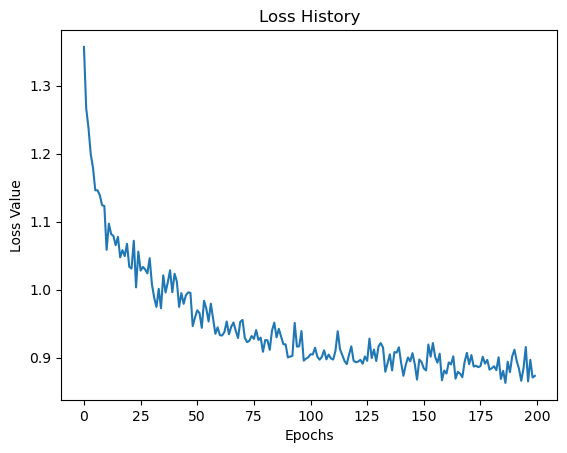

In [28]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/training_loss_history_1d_cnn_two_blocks_sgd.pdf", bbox_inches="tight")
plt.show()

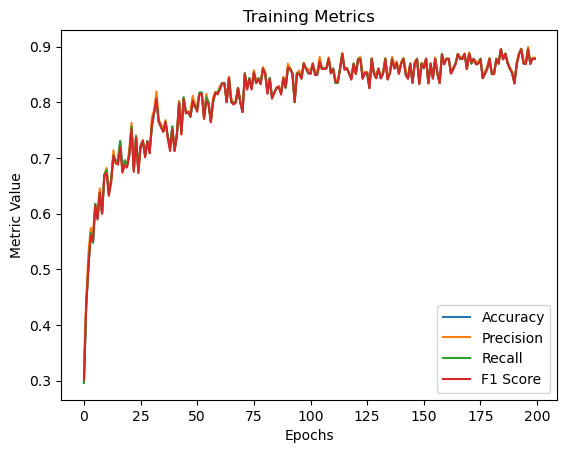

In [29]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_1d_cnn_two_blocks_sgd.pdf", bbox_inches="tight")
plt.show()

In [30]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.8125652173913042
Mean Training Precision: 0.8149108240811106
Mean Training Recall: 0.8125652173913042
Mean Training F1 Score: 0.8115169650562669


In [31]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [32]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted')
  recall = recall_score(yhat, y, average='weighted')
  f1 = f1_score(yhat, y, average='weighted')

In [33]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.4533002376556396
Testing Accuracy: 0.2413793103448276
Testing Precision: 0.47643678160919534
Testing Recall: 0.2413793103448276
Testing F1 Score: 0.2607994703946728


## Adam

In [34]:
model = Model()
model = model.to(DEVICE)
model

Model(
  (conv_block1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_block2): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): Dropout(p=0.3, inplace=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dense): Linear(in_features=10176, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [35]:
summary(model, input_data=sample_x)

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [8, 4]                    --
├─Sequential: 1-1                        [8, 64, 479]              --
│    └─Conv1d: 2-1                       [8, 64, 1438]             256
│    └─MaxPool1d: 2-2                    [8, 64, 479]              --
│    └─Dropout: 2-3                      [8, 64, 479]              --
│    └─BatchNorm1d: 2-4                  [8, 64, 479]              128
├─Sequential: 1-2                        [8, 64, 159]              --
│    └─Conv1d: 2-5                       [8, 64, 477]              12,352
│    └─MaxPool1d: 2-6                    [8, 64, 159]              --
│    └─Dropout: 2-7                      [8, 64, 159]              --
│    └─BatchNorm1d: 2-8                  [8, 64, 159]              128
├─Linear: 1-3                            [8, 4]                    40,708
├─Softmax: 1-4                           [8, 4]                    --
Tota

In [36]:
tb_board = RUNS_PATH + "1d_cnn_two_blocks_adam"
writer = SummaryWriter(tb_board)

In [37]:
EPOCHS = 200

acc_list = []
f1_list = []
recall_list = []
precision_list = []

loss_list = []

In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [39]:
for epoch in range(EPOCHS):
  model.train()
  running_loss = 0.0

  labels_list = []
  preds_list = []

  for (x, y) in train_loader:
    x, y = x.to(DEVICE), y.to(DEVICE)

    yhat = model(x)

    labels_list.extend(y.cpu())
    preds_list.extend(yhat.argmax(1).cpu())

    loss = loss_fn(yhat, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  avg_loss = running_loss / len(train_loader)
  loss_list.append(avg_loss)

  acc = accuracy_score(labels_list, preds_list)
  pre = precision_score(labels_list, preds_list, average='weighted', zero_division=0)
  rec = recall_score(labels_list, preds_list, average='weighted', zero_division=0)
  f1 = f1_score(labels_list, preds_list, average='weighted', zero_division=0)

  acc_list.append(acc)
  precision_list.append(pre)
  recall_list.append(rec)
  f1_list.append(f1)

  writer.add_scalar("Train/Loss", avg_loss, epoch)
  writer.add_scalar("Train/Accuracy", acc, epoch)
  writer.add_scalar("Train/Precision", pre, epoch)
  writer.add_scalar("Train/Recall", rec, epoch)
  writer.add_scalar("Train/F1", f1, epoch)

  print(f"Epoch: {epoch + 1} - Loss: {avg_loss} - Accuracy: {acc} - Precision: {pre} - Recall: {rec} - F1: {f1}")

Epoch: 1 - Loss: 1.3613394419352214 - Accuracy: 0.2782608695652174 - Precision: 0.3060102301790281 - Recall: 0.2782608695652174 - F1: 0.27889841175668856
Epoch: 2 - Loss: 1.315933362642924 - Accuracy: 0.3739130434782609 - Precision: 0.4195274571151149 - Recall: 0.3739130434782609 - F1: 0.3845678001335467
Epoch: 3 - Loss: 1.2131298581759136 - Accuracy: 0.5043478260869565 - Precision: 0.536886341903721 - Recall: 0.5043478260869565 - F1: 0.5128186473856899
Epoch: 4 - Loss: 1.180073654651642 - Accuracy: 0.5391304347826087 - Precision: 0.5948741418764303 - Recall: 0.5391304347826087 - F1: 0.5548530945445391
Epoch: 5 - Loss: 1.1842256267865499 - Accuracy: 0.5652173913043478 - Precision: 0.5645962732919255 - Recall: 0.5652173913043478 - F1: 0.5594202898550724
Epoch: 6 - Loss: 1.1503025730450949 - Accuracy: 0.5391304347826087 - Precision: 0.5511848067097271 - Recall: 0.5391304347826087 - F1: 0.5418002088210874
Epoch: 7 - Loss: 1.1208882252375285 - Accuracy: 0.6347826086956522 - Precision: 0.63

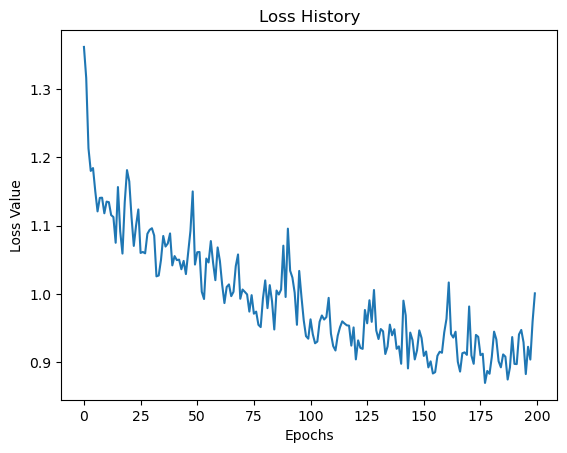

In [40]:
plt.title("Loss History")
plt.plot(range(EPOCHS), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.savefig("figures/training_loss_history_1d_cnn_two_blocks_adam.pdf", bbox_inches="tight")
plt.show()

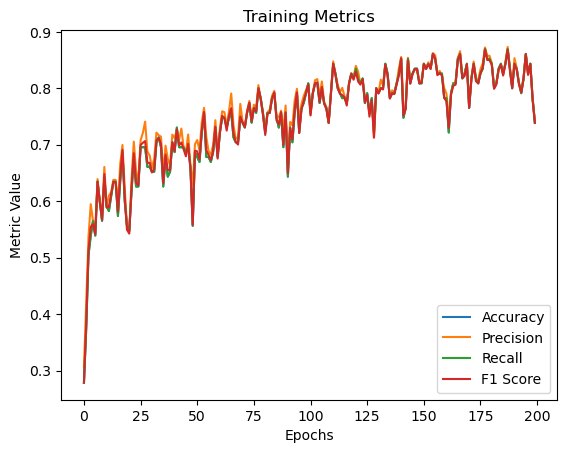

In [41]:
plt.title("Training Metrics")
plt.plot(range(EPOCHS), acc_list, label="Accuracy")
plt.plot(range(EPOCHS), precision_list, label="Precision")
plt.plot(range(EPOCHS), recall_list, label="Recall")
plt.plot(range(EPOCHS), f1_list, label="F1 Score")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Metric Value")
plt.savefig("figures/training_metrics_1d_cnn_two_blocks_adam.pdf", bbox_inches="tight")
plt.show()

In [42]:
print(f"Mean Training Accuracy: {np.array(acc_list).mean()}")
print(f"Mean Training Precision: {np.array(precision_list).mean()}")
print(f"Mean Training Recall: {np.array(recall_list).mean()}")
print(f"Mean Training F1 Score: {np.array(f1_list).mean()}")

writer.add_scalar("Train/Mean Accuracy", np.array(acc_list).mean(), 0)
writer.add_scalar("Train/Mean Precision", np.array(precision_list).mean(), 0)
writer.add_scalar("Train/Mean Recall", np.array(recall_list).mean(), 0)
writer.add_scalar("Train/Mean F1 Score", np.array(f1_list).mean(), 0)

Mean Training Accuracy: 0.7468260869565218
Mean Training Precision: 0.7555005452844219
Mean Training Recall: 0.7468260869565218
Mean Training F1 Score: 0.7474256460338984


In [43]:
loss = 0.0
accuracy = 0.0
precision = 0.0
recall = 0.0
f1 = 0.0

In [44]:
model.eval()
with torch.no_grad():
  x = torch.tensor(test_data).type(torch.FloatTensor)
  y = torch.tensor(test_labels).type(torch.LongTensor)

  yhat = model(x)

  yhat = yhat.cpu()
  loss = loss_fn(yhat, y)

  yhat = yhat.argmax(1)
  accuracy = accuracy_score(yhat, y)
  precision = precision_score(yhat, y, average='weighted', zero_division=0)
  recall = recall_score(yhat, y, average='weighted', zero_division=0)
  f1 = f1_score(yhat, y, average='weighted', zero_division=0)

In [45]:
print(f"Testing Loss: {loss}")
print(f"Testing Accuracy: {accuracy}")
print(f"Testing Precision: {precision}")
print(f"Testing Recall: {recall}")
print(f"Testing F1 Score: {f1}")

writer.add_scalar("Test/Loss", loss, 0)
writer.add_scalar("Test/Accuracy", accuracy, 0)
writer.add_scalar("Test/Precision", precision, 0)
writer.add_scalar("Test/Recall", recall, 0)
writer.add_scalar("Test/F1 Score", f1, 0)

Testing Loss: 1.4267899990081787
Testing Accuracy: 0.27586206896551724
Testing Precision: 0.3847701149425287
Testing Recall: 0.27586206896551724
Testing F1 Score: 0.28680371352785144
